In [1]:
# Verify that we are using the correct Python (/home/ata/miniconda3/envs/ml/bin/)
!which python
!which jupyter

/home/ata/miniconda3/envs/ml-2/bin/python
/home/ata/miniconda3/envs/ml-2/bin/jupyter


In [2]:
# Import the class from the Python file (module)
import pandas as pd
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from BinanceClient import BinanceClient
import numpy as np
from typing import Final
import joblib
from BatchFeatures import BatchFeatures
from LeadingSwingDetector import LeadingSwingDetector
from datetime import datetime, timedelta
%matplotlib widget

#### Fetch pair data

In [3]:
# Initialize Binance client with your API credentials
# dotenv_path = Path('.env-secret')
# load_dotenv(dotenv_path=dotenv_path)
api_secret = os.getenv("BINANCE_SECRET_KEY")
api_key = os.getenv("BINANCE_API_KEY")

# Create Binance client & initialize it
pair = "BTCUSDT"
time_delta = 60
db_name = pair + "_1min_" + str(time_delta) + "weeks"
binance_client = BinanceClient(db_name)
binance_client.set_interval("1m")
batch_feature = BatchFeatures()


#### Fecth Data from Binance

In [26]:
# Create connection to fetch data
binance_client.make(api_key, api_secret)

# Get current server time
server_time = binance_client.get_server_time()

# Compute start and end time for the last x hours
server_time_dt = datetime.fromtimestamp(server_time['serverTime'] / 1000, tz=datetime.timezone.utc if hasattr(datetime, 'timezone') else None)
end_date = server_time_dt
start_date = server_time_dt - timedelta(hours=time_delta)
start_date_str = int(start_date.timestamp() * 1000)  # Convert to milliseconds
end_date_str = int(end_date.timestamp() * 1000)      # Convert to milliseconds

# Fetch data
data = binance_client.fetch_data(pair, start_date_str, end_date_str)
binance_client.store_data_to_db(pair, data)

# Check if data is fetched
if not data.empty:
    # Convert the fetched data into a pandas DataFrame
    df = data
else:
    print("No data found!!!.")

Fetching data from Binance API...


#### Fetch data from db

In [4]:
#Fetch data from db
df = binance_client.fetch_data_from_db(pair)

#### Define target 

In [ ]:
def detect_swing_points(df, left_bars=3, right_bars=3):
    """
    Detect swing highs and swing lows in price data.
    A swing high is a high that is greater than highs in the left and right window.
    A swing low is a low that is lower than lows in the left and right window.

    Args:
        df (pd.DataFrame): DataFrame with 'high' and 'low' columns.
        left_bars (int): Number of bars to the left to compare.
        right_bars (int): Number of bars to the right to compare.

    Returns:
        df (pd.DataFrame): DataFrame with 'swing_high' and 'swing_low' columns marked as True/False.
    """
    highs = df['high'].values
    lows = df['low'].values
    length = len(df_processed)

    swing_highs = np.full(length, False)
    swing_lows = np.full(length, False)

    for i in range(left_bars, length - right_bars):
        if all(highs[i] > highs[i - j - 1] for j in range(left_bars)) and \
           all(highs[i] > highs[i + j + 1] for j in range(right_bars)):
            swing_highs[i] = True
        if all(lows[i] < lows[i - j - 1] for j in range(left_bars)) and \
           all(lows[i] < lows[i + j + 1] for j in range(right_bars)):
            swing_lows[i] = True

    df['swing_high'] = swing_highs
    df['swing_low'] = swing_lows

    return df

In [15]:
def classify_trend(df, min_length=10):
    """
    Classify trend segments based on swing highs/lows into uptrend or downtrend.
    This is done by checking if the sequence of swing highs and lows is making higher highs/lows (uptrend)
    or lower highs/lows (downtrend).

    Adds a 'trend' column with values: 'uptrend', 'downtrend', or 'no clear trend'

    Args:
        df (pd.DataFrame): DataFrame with 'swing_high' and 'swing_low' columns.
        min_length (int): Minimum number of bars required to classify a trend segment.

    Returns:
        df (pd.DataFrame): DataFrame with new 'trend' classification column.
    """
    # Extract swing points as a list of tuples (index, price, type)
    swings = []
    for i, row in df.iterrows():
        if row['swing_high']:
            swings.append((i, row['high'], 'high'))
        elif row['swing_low']:
            swings.append((i, row['low'], 'low'))

    trends = ['no clear trend'] * len(df)

    # We need at least two swing highs and two swing lows to determine trend
    highs = [s for s in swings if s[2] == 'high']
    lows = [s for s in swings if s[2] == 'low']

    # Iterate through swings to identify trend segments
    for i in range(1, len(swings)):
        curr = swings[i]
        prev = swings[i - 1]

        if curr[2] == 'high' and prev[2] == 'high':
            if curr[1] > prev[1]:
                # Higher high detected - potential uptrend
                prev_lows = [l[1] for l in lows if l[0] < curr[0]]
                if len(prev_lows) >= 2 and prev_lows[-1] > prev_lows[-2]:
                    # Higher low also detected
                    start_idx = df.index.get_loc(prev[0])
                    end_idx = df.index.get_loc(curr[0])
                    segment_length = end_idx - start_idx + 1
                    if segment_length >= min_length:
                        for idx in range(start_idx, end_idx + 1):
                            trends[idx] = 'uptrend'

        elif curr[2] == 'low' and prev[2] == 'low':
            if curr[1] < prev[1]:
                # Lower low detected - potential downtrend
                prev_highs = [h[1] for h in highs if h[0] < curr[0]]
                if len(prev_highs) >= 2 and prev_highs[-1] < prev_highs[-2]:
                    # Lower high also detected
                    start_idx = df.index.get_loc(prev[0])
                    end_idx = df.index.get_loc(curr[0])
                    segment_length = end_idx - start_idx + 1
                    if segment_length >= min_length:
                        for idx in range(start_idx, end_idx + 1):
                            trends[idx] = 'downtrend'

        else:
            # Mixed swings, trend uncertain here
            pass

    df['trend'] = trends
    return df


In [70]:
def detect_leading_swings(df, left_bars=3):
    """
    Detect potential swing highs/lows using only left_bars lookback.
    This identifies a swing high/low as a point higher/lower than the previous left_bars bars,
    without a right side confirmation, allowing detection as soon as price moves form.

    Args:
        df (pd.DataFrame): DataFrame with 'high' and 'low'.
        left_bars (int): The number of previous bars to compare.

    Returns:
        df (pd.DataFrame): DataFrame with 'swing_high' and 'swing_low' columns (bool).
    """
    highs = df['high'].values
    lows = df['low'].values
    length = len(df)

    swing_highs = np.full(length, False)
    swing_lows = np.full(length, False)

    for i in range(left_bars, length):
        if all(highs[i] > highs[i - j - 1] for j in range(left_bars)):
            swing_highs[i] = True
        if all(lows[i] < lows[i - j - 1] for j in range(left_bars)):
            swing_lows[i] = True

    df['swing_high'] = swing_highs
    df['swing_low'] = swing_lows

    return df


In [5]:
df.head()

,open,high,low,close,volume
timestamp,,,,,
2025-08-05 22:21:00,113769.37,113778.65,113769.37,113778.65,1.07562
2025-08-05 22:22:00,113778.65,113785.00,113758.99,113785.00,2.45069
2025-08-05 22:23:00,113785.00,113797.20,113785.00,113797.20,0.79736
2025-08-05 22:24:00,113797.19,113833.97,113797.19,113833.97,1.77772
2025-08-05 22:25:00,113833.96,113833.97,113800.00,113800.00,2.67422


In [6]:
plt.close('all')

In [83]:
# Assuming your dataframe is `df` with datetime index and columns including 'high' & 'low'
# df = detect_swing_points(df, left_bars=10, right_bars=0)
left_bars = 5
df = detect_leading_swings(df, left_bars)
df = classify_trend(df, left_bars)

# Inspect the trend column to see where uptrends and downtrends are detected
# print(df[['high', 'low', 'swing_high', 'swing_low', 'trend']].tail(50))

In [36]:
def refine_trend(df):
    trend = []

    for i in range(len(df)):
        # EMA condition
        ema_bull = (df['EMA_7'][i] > df['EMA_25'][i]) and (df['EMA_25'][i] > df['EMA_99'][i]) and (df['close'][i] > df['EMA_7'][i])
        ema_bear = (df['EMA_7'][i] < df['EMA_25'][i]) and (df['EMA_25'][i] < df['EMA_99'][i]) and (df['close'][i] < df['EMA_7'][i])

        # RSI and Stoch for momentum
        rsi_bull = df['RSI'][i] > 50
        rsi_bear = df['RSI'][i] < 50
        stoch_bull = df['stoch_oscillator'][i] > 50
        stoch_bear = df['stoch_oscillator'][i] < 50

        # MACD crossover
        macd_bull = df['MACD_line'][i] > df['MACD_signal'][i]
        macd_bear = df['MACD_line'][i] < df['MACD_signal'][i]

        # ATR threshold filter (e.g., above median ATR)
        atr_active = df['ATR'][i] > df['ATR'].median()

        # Volume confirmation
        vol_bull = df['OBV'][i] > df['OBV'].shift(1)[i]
        vol_bear = df['OBV'][i] < df['OBV'].shift(1)[i]

        # Check swing conditions
        swing_low_confirm = df['swing_low'][i] == True
        swing_high_confirm = df['swing_high'][i] == True

        # Evaluate combined bullish trend
        if ema_bull and rsi_bull and stoch_bull and macd_bull and atr_active and vol_bull and (swing_low_confirm or True):
            trend.append('uptrend')

        # Evaluate combined bearish trend
        elif ema_bear and rsi_bear and stoch_bear and macd_bear and atr_active and vol_bear and (swing_high_confirm or True):
            trend.append('downtrend')

        else:
            trend.append('no clear trend')
    
    df['refined_trend'] = trend
    return df


In [ ]:
# Assuming:
# - df is your full DataFrame indexed by timestamp
# - LeadingSwingDetector class is already defined and imported

# Set batch size -- how many rows per batch you want to process incrementally
BATCH_SIZE = 100
left_bars = 2

# Initialize detector
detector = LeadingSwingDetector(left_bars)

# Prepare container for processed batches
processed_batches = []

# Iterate through df in chunks/batches using integer location (iloc)
for start_idx in range(0, len(df), BATCH_SIZE):
    end_idx = min(start_idx + BATCH_SIZE, len(df))
    batch_df = df.iloc[start_idx:end_idx]

    # Detect swings incrementally on this batch
    batch_with_swings = detector.detect_leading_swings_incremental(batch_df)

    # Append to list
    processed_batches.append(batch_with_swings)

# Optionally, concatenate all batches back into a full DataFrame
df_processed = pd.concat(processed_batches)

# This df_processed now has incremental swing detection applied batch-wise
# print(df_processed[['high', 'low', 'swing_high', 'swing_low']].tail(20))

df_processed = classify_trend(df_processed, left_bars)

# Feature Engineering (mind the order since some features are depended on others)
bf = BatchFeatures()
bf.calculate_sma(df_processed)
bf.calculate_ema(df_processed)
bf.calculate_rsi(df_processed)
bf.calculate_macd(df_processed)
bf.calculate_bollinger_bands(df_processed)
bf.calculate_atr(df_processed)
bf.calculate_volume_features(df_processed)
bf.calculate_roc(df_processed)
bf.calculate_lagged_features(df_processed)
bf.calculate_candle_features(df_processed)
bf.calculate_stochastic_oscillator(df_processed)
bf.calculate_williams_r(df_processed)
bf.calculate_moving_average_crossover(df_processed)
bf.calculate_historical_volatility(df_processed)
bf.calculate_on_balance_volume(df_processed)
bf.calculate_money_flow_index(df_processed)
bf.calculate_croc(df_processed)



In [35]:
df_processed.head()

,open,high,low,close,volume,swing_high,swing_low,trend
timestamp,,,,,,,,
2025-08-05 22:21:00,113769.37,113778.65,113769.37,113778.65,1.07562,False,False,no clear trend
2025-08-05 22:22:00,113778.65,113785.00,113758.99,113785.00,2.45069,False,False,no clear trend
2025-08-05 22:23:00,113785.00,113797.20,113785.00,113797.20,0.79736,True,False,no clear trend
2025-08-05 22:24:00,113797.19,113833.97,113797.19,113833.97,1.77772,True,False,no clear trend
2025-08-05 22:25:00,113833.96,113833.97,113800.00,113800.00,2.67422,False,False,no clear trend


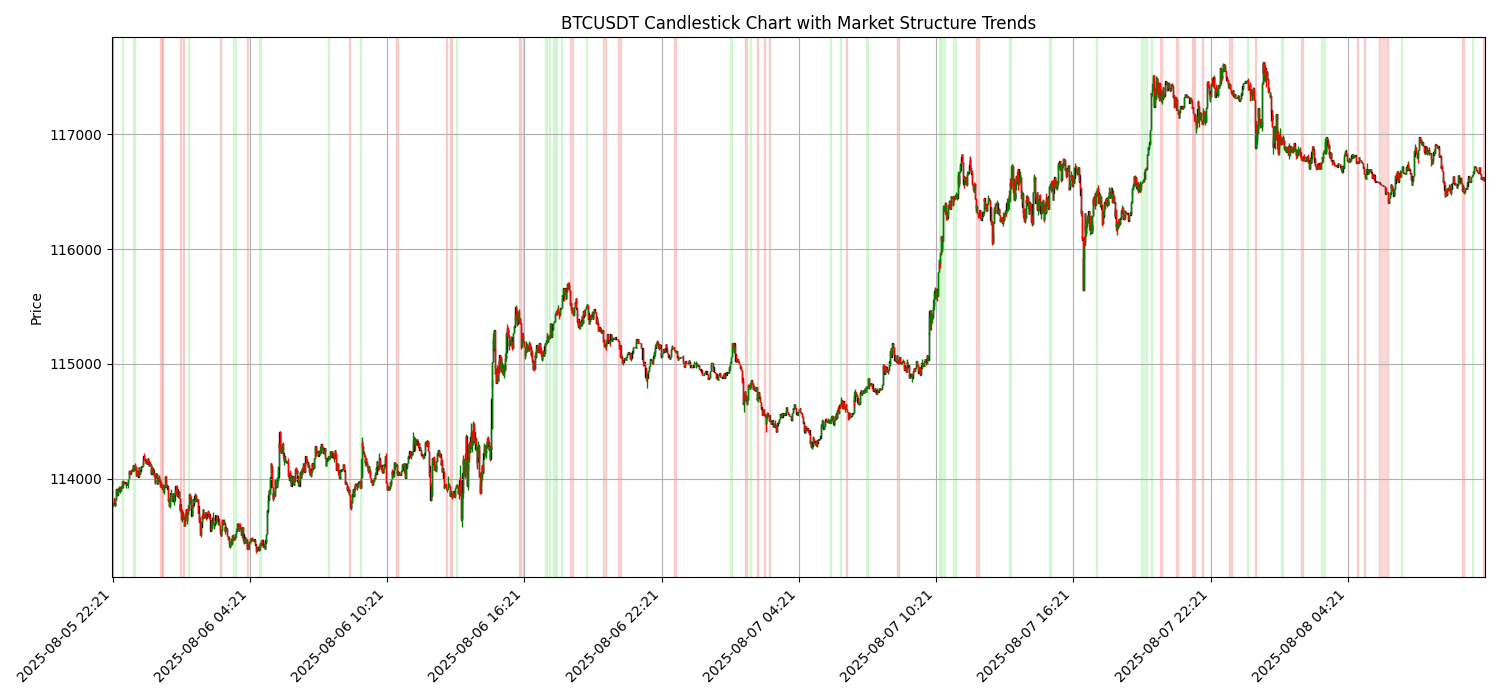

In [32]:
plot_candlesticks_with_trends(df_processed)

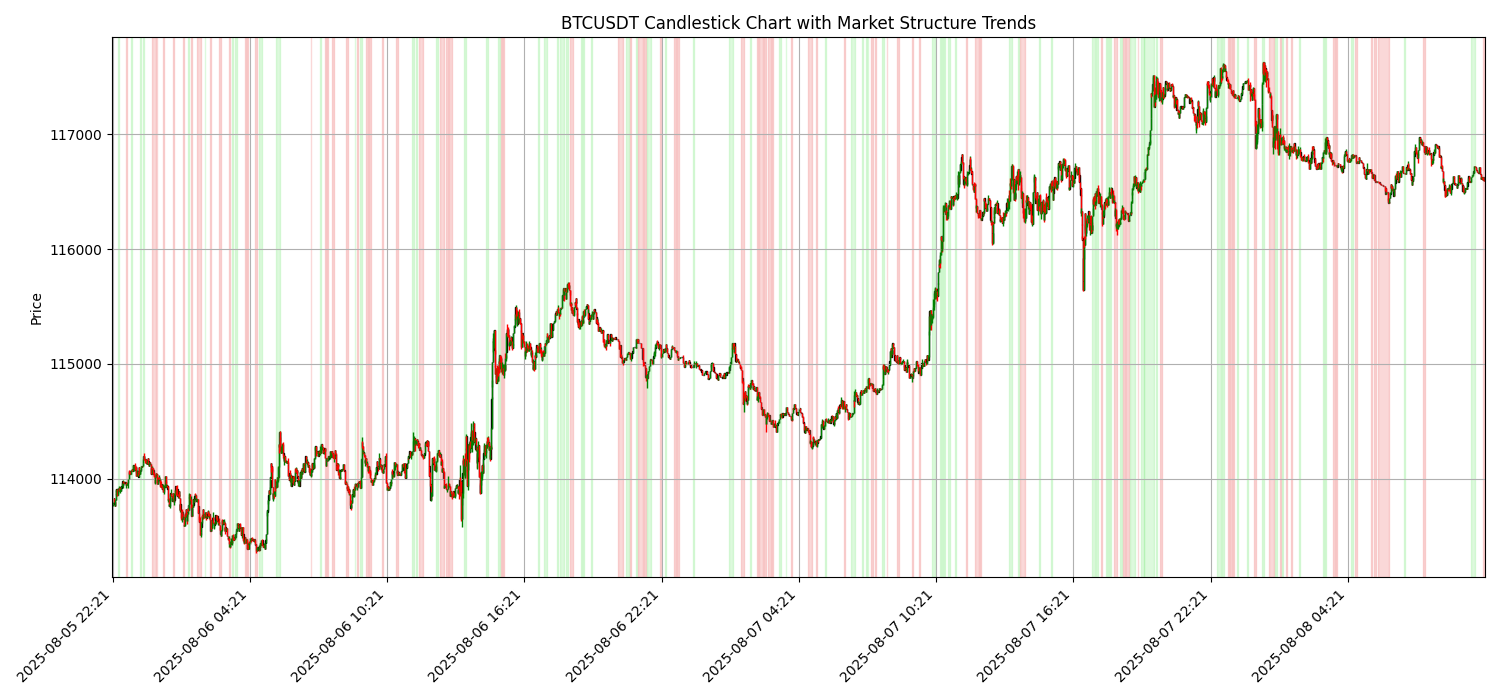

In [34]:
plot_candlesticks_with_trends(df_processed)

In [34]:
df.head()

,open,high,low,close,volume,swing_high,swing_low,trend
timestamp,,,,,,,,
2025-08-05 22:21:00,113769.37,113778.65,113769.37,113778.65,1.07562,False,False,no clear trend
2025-08-05 22:22:00,113778.65,113785.00,113758.99,113785.00,2.45069,False,False,no clear trend
2025-08-05 22:23:00,113785.00,113797.20,113785.00,113797.20,0.79736,False,False,no clear trend
2025-08-05 22:24:00,113797.19,113833.97,113797.19,113833.97,1.77772,False,False,no clear trend
2025-08-05 22:25:00,113833.96,113833.97,113800.00,113800.00,2.67422,False,False,no clear trend


In [49]:
df.describe()

,open,high,low,close,volume
count,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000
mean,115400.391825,115418.967036,115381.741586,115401.172289,7.790247
std,1211.703650,1212.626119,1210.145302,1211.557530,11.063920
min,113373.760000,113390.010000,113355.130000,113373.760000,0.194840
25%,114245.685000,114269.720000,114223.862500,114245.687500,2.361287
50%,115119.080000,115137.545000,115101.800000,115120.030000,4.348100
75%,116585.255000,116605.707500,116572.655000,116585.877500,8.579115
max,117627.550000,117630.000000,117595.990000,117627.550000,189.094400


In [20]:
def plot_candlesticks_with_trends(df_local):
    """
    Plot BTCUSDT candlestick chart with detected market structure trends overlaid as background colored regions.
    
    Args:
        df (pd.DataFrame): DataFrame indexed by datetime with columns:
            'open', 'high', 'low', 'close', and a 'trend' column with values 
            'uptrend', 'downtrend', or 'no clear trend'.
    """
    dates = np.arange(len(df_local))
    trends = df_local['trend'].fillna('no clear trend').values
    
    openp = df_local['open'].values
    highp = df_local['high'].values
    lowp = df_local['low'].values
    closep = df_local['close'].values
    
    fig, ax = plt.subplots(figsize=(15, 7))
    
    width = 0.6
    width2 = 0.1

    # Plot candlesticks
    for i in range(len(df_local)):
        color = 'green' if closep[i] >= openp[i] else 'red'
        # Wick
        ax.vlines(dates[i], lowp[i], highp[i], color=color, linewidth=1)
        # Body
        if closep[i] >= openp[i]:
            ax.bar(dates[i], closep[i]-openp[i], width, bottom=openp[i], color='green', edgecolor='black')
        else:
            ax.bar(dates[i], openp[i]-closep[i], width, bottom=closep[i], color='red', edgecolor='black')
    
    # Overlay trend regions as colored background spans
    last_trend = None
    start_idx = 0

    for i in range(len(trends) + 1):
        if i == len(trends) or trends[i] != last_trend:
            if last_trend in ['uptrend', 'downtrend']:
                color = 'lightgreen' if last_trend == 'uptrend' else 'lightcoral'
                ax.axvspan(start_idx - 0.5, i - 0.5, color=color, alpha=0.3)
            if i < len(trends):
                start_idx = i
                last_trend = trends[i]
        elif last_trend is None:
            last_trend = trends[i]

    # Formatting x-axis with datetime labels
    ax.set_xticks(dates[::max(1, len(dates)//10)])
    ax.set_xticklabels([dt.strftime('%Y-%m-%d %H:%M') for dt in df_local.index[::max(1, len(dates)//10)]], rotation=45, ha='right')
    
    ax.set_xlim(-1, len(df_local))
    ax.set_ylabel('Price')
    ax.set_title('BTCUSDT Candlestick Chart with Market Structure Trends')
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()
# Usage:
# After computing the trend column in your df:
# df = detect_swing_points(df, left_bars=3, right_bars=3)
# df = classify_trend(df)
# plot_trends_only(df)
